<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab%20/CUDA-QX/cudaqx_qaoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cudaq-solvers==0.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 3.9 MB/s eta 0:00:00


# Quantum Approximate Optimization Algorithm

The **Quantum Approximate Optimization Algorithm (QAOA)** is a variational quantum algorithm designed to solve combinatorial optimization problems. It operates by alternating between two quantum operators:  
1. **Cost Hamiltonian** – Encodes the problem constraints.  
2. **Mixer Hamiltonian** – Introduces transitions between states.  

By optimizing parameters in these operations, QAOA aims to find high-quality approximate solutions to problems like **Max-Cut** and **QUBO** (quadratic unconstrained binary optimization) on near-term quantum devices. To learn more details, [here](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/01_Max-Cut-with-QAOA.ipynb) in a well-structured tutorial.

The coefficient matrix for Max-Cut is constructed based on the graph structure using the standard QUBO formulation:  

$$
H = 1/2\sum_{(i, j) \in E} w_{ij}(I-Z_i Z_j)
$$  

where:
- $Z_i$ represents the Pauli-Z operator for qubit (node) $i$.
- Each edge $(i, j)$ contributes a term $w_{ij}(I-Z_i Z_j)/2$,  
- If nodes $i$ and $j$ are assigned to different groups, they contribute a cut of weight $w_{ij}$; otherwise, the contribution is $0$.

Let's start from an example graph:

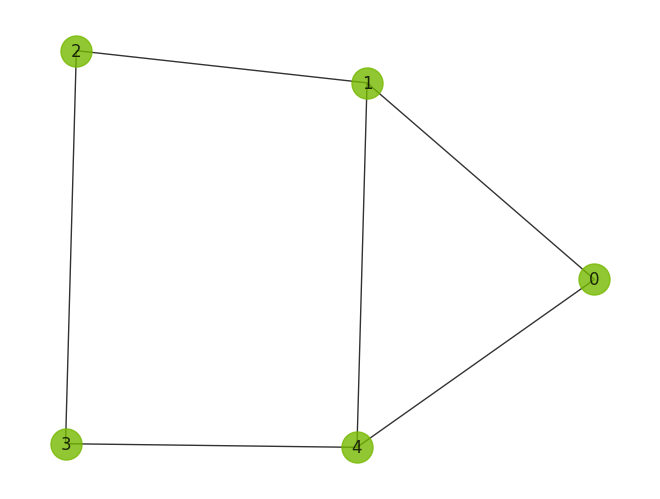

In [2]:
import networkx as nx


G=nx.Graph()
G.add_weighted_edges_from([(0, 1, 1), (1, 2, 1), (1, 4, 1), (2, 3, 1), (3, 4, 1), (4, 0, 1)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='#76B900')

Note that maximizing $H = \frac{1}{2} \sum_{(i, j) \in E} w_{ij} (I - Z_i Z_j)$ is equivalent to simply minimizing $ \sum_{(i, j) \in E} w_{ij} Z_i Z_j$.
Then we can construct the simplified Hamiltonian and the coefficient matrix accordingly:

In [3]:
import numpy as np


# Initialize coefficient matrix
coefficient_matrix = np.zeros((G.number_of_nodes(), G.number_of_nodes()))

# Fill the matrix with negative edge weights for Max-Cut
for i, j, w in G.edges(data=True):
    coefficient_matrix[i, j] = w['weight']
    coefficient_matrix[j, i] = w['weight']  # Since the graph is undirected

print(coefficient_matrix)

[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]]


In [4]:
import cudaq
from cudaq import spin


# Flatten the coefficient matrix
flattened_matrix = coefficient_matrix.flatten()

# Number of qubits (original matrix is square)
qubit_count = coefficient_matrix.shape[0]

# Construct Hamiltonian using the flattened matrix
hamiltonian = 0
for idx, value in enumerate(flattened_matrix):
    if value != 0:
        i = idx // qubit_count  # Row index
        j = idx % qubit_count   # Column index

        if i == j:
            hamiltonian += value * spin.z(i)  # First-order term
        elif i < j:  # For symmetric matrices
            hamiltonian += value * spin.z(i) * spin.z(j)  # Second-order term

# Print the Hamiltonian
print("Problem Hamiltonian:", hamiltonian)

Problem Hamiltonian: [1+0j] ZIIIZ
[1+0j] IZZII
[1+0j] IZIIZ
[1+0j] IIIZZ
[1+0j] IIZZI
[1+0j] ZZIII
[0+0j] IIIII



In [5]:
import cudaq_solvers as solvers
from scipy.optimize import minimize
from typing import List


# Parameters of QAOA
layer_count = 2
parameter_count = 2 * layer_count

@cudaq.kernel
def kernel_qaoa(thetas: List[float]):
    """QAOA ansatz for Max-Cut using the flattened coefficient matrix."""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over layers
    for layer in range(layer_count):
        for idx, value in enumerate(flattened_matrix):
            if value != 0:
                i = idx // qubit_count  # Row index
                j = idx % qubit_count   # Column index

                if i == j:
                    # Apply Rz gate for first-order terms
                    rz(2.0 * value * thetas[layer], qvector[i])
                elif i < j:
                    # Apply CNOT-Rz-CNOT for second-order terms
                    x.ctrl(qvector[i], qvector[j])
                    rz(2.0 * value * thetas[layer], qvector[j])
                    x.ctrl(qvector[i], qvector[j])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the initial parameters and visualize the kernel
np.random.seed(13)
initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
print("Initial parameters = ", initial_parameters)
print(cudaq.draw(kernel_qaoa, initial_parameters))

Initial parameters =  [ 0.21810696 -0.20613464  0.25468776  0.36579856]
     ╭───╮                                                ╭────────────╮»
q0 : ┤ h ├──●──────────────────●────●──────────────────●──┤ rx(0.5094) ├»
     ├───┤╭─┴─╮╭────────────╮╭─┴─╮  │                  │  ╰────────────╯»
q1 : ┤ h ├┤ x ├┤ rz(0.4362) ├┤ x ├──┼──────────────────┼────────●───────»
     ├───┤╰───╯╰────────────╯╰───╯  │                  │      ╭─┴─╮     »
q2 : ┤ h ├──────────────────────────┼──────────────────┼──────┤ x ├─────»
     ├───┤                          │                  │      ╰───╯     »
q3 : ┤ h ├──────────────────────────┼──────────────────┼────────────────»
     ├───┤                        ╭─┴─╮╭────────────╮╭─┴─╮              »
q4 : ┤ h ├────────────────────────┤ x ├┤ rz(0.4362) ├┤ x ├──────────────»
     ╰───╯                        ╰───╯╰────────────╯╰───╯              »

################################################################################

                               

In [6]:
# Optimize through cudaq-solver with the GPU backend

#cudaq.set_target('qpp-cpu')  # Use 'qpp-cpu' for simulation on CPU

expectation, optimized_parameters, _ = solvers.vqe(kernel_qaoa,
                                              hamiltonian,
                                              initial_parameters,
                                              optimizer=minimize,
                                              method='L-BFGS-B',
                                              jac='3-point',
                                              tol=1e-5,
                                              options={'disp': True})
print(f'Final  = {expectation}')

Final  = -3.2468595165487435


In [7]:
# Sample the circuit using the optimized parameters and find the most probable bitstring with the maximum cut value
counts = cudaq.sample(kernel_qaoa, optimized_parameters, shots_count=2**(qubit_count+5))
print(counts.most_probable())

11010
